# 소리 검색 - environmental sound

modified from https://github.com/aqibsaeed/Urban-Sound-Classification/blob/master/Convolutional%20Neural%20Network.ipynb

data from UrbanSound https://www.kaggle.com/mmoreaux/environmental-sound-classification-50

# 데이터 준비

In [1]:
!wget https://github.com/dhrim/deep_learning_data/raw/master/environmental_sound.zip

--2022-01-26 06:10:59--  https://github.com/dhrim/deep_learning_data/raw/master/environmental_sound.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/dhrim/deep_learning_data/master/environmental_sound.zip [following]
--2022-01-26 06:10:59--  https://media.githubusercontent.com/media/dhrim/deep_learning_data/master/environmental_sound.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128879389 (123M) [application/zip]
Saving to: ‘environmental_sound.zip’

environmental_sound 100%[===================>] 122.91M   237MB/s    in 0.5s    

2022-01-26 06:11:02 (237 MB/s) - ‘environ

In [2]:
!unzip environmental_sound

Archive:  environmental_sound.zip
   creating: environmental_sound/
  inflating: environmental_sound/1-96950-B-9.wav  
  inflating: environmental_sound/3-160993-A-3.wav  
  inflating: environmental_sound/1-47819-A-5.wav  
  inflating: environmental_sound/4-234644-A-2.wav  
  inflating: environmental_sound/2-103424-A-3.wav  
  inflating: environmental_sound/2-32515-A-4.wav  
  inflating: environmental_sound/5-214759-B-5.wav  
  inflating: environmental_sound/3-110913-D-7.wav  
  inflating: environmental_sound/4-161303-B-5.wav  
  inflating: environmental_sound/1-17970-A-4.wav  
  inflating: environmental_sound/1-15689-A-4.wav  
  inflating: environmental_sound/2-71162-A-1.wav  
  inflating: environmental_sound/5-200334-B-1.wav  
  inflating: environmental_sound/5-263831-A-6.wav  
  inflating: environmental_sound/1-260640-A-2.wav  
  inflating: environmental_sound/2-52085-A-4.wav  
  inflating: environmental_sound/2-95258-B-1.wav  
  inflating: environmental_sound/4-154793-A-4.wav  
  in

In [1]:
import IPython.display as ipd
display(ipd.Audio('environmental_sound/1-56234-A-9.wav'))
display(ipd.Audio('environmental_sound/5-234879-B-1.wav'))

In [2]:
import librosa

sound_clip, sampling_ratio = librosa.load('environmental_sound/5-234879-B-1.wav')

import matplotlib.pyplot as plt
print(type(sound_clip))
print(sound_clip.shape)
print(sound_clip[:10])
print("sampling_ratio =",sampling_ratio)

import IPython
IPython.display.Audio(data=sound_clip, rate=sampling_ratio)

<class 'numpy.ndarray'>
(110250,)
[ 0.00329883  0.00486267  0.00491556  0.00438946  0.00269288  0.00156996
  0.00086251 -0.00150766 -0.00557174 -0.00884038]
sampling_ratio = 22050


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


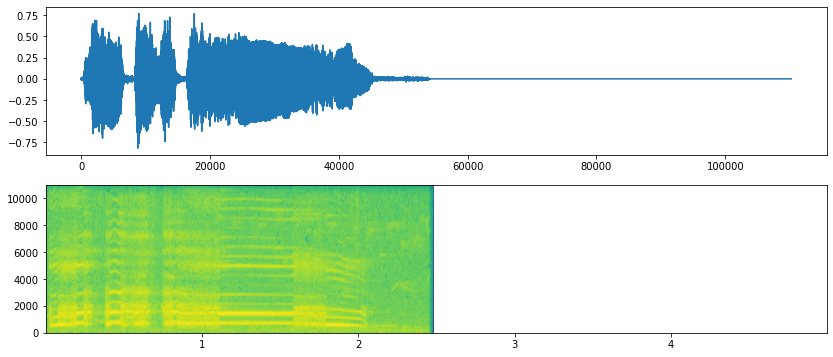

In [3]:
plt.figure(figsize=(14,6))
plt.subplot(211)
plt.plot(sound_clip)

plt.subplot(212)
plt.specgram(sound_clip,Fs=sampling_ratio)

plt.show()

# 데이터 로딩

In [4]:
import glob
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

In [5]:
import glob
import random

file_names = glob.glob("environmental_sound/*.wav")
print(file_names[:3])
random.shuffle(file_names)
print(file_names[:3])


total_file_count = len(file_names)
train_file_count = int(total_file_count * 0.8)

train_file_names = file_names[:train_file_count]
test_file_names = file_names[train_file_count:]
print(total_file_count)
print(len(train_file_names), len(test_file_names))

['environmental_sound/1-31251-A-6.wav', 'environmental_sound/4-188703-B-8.wav', 'environmental_sound/5-253085-B-3.wav']
['environmental_sound/5-244315-B-6.wav', 'environmental_sound/4-196671-B-8.wav', 'environmental_sound/5-194899-B-3.wav']
400
320 80


# Data Generator

In [6]:
BATCH_SIZE = 16

In [7]:
import numpy as np
import math
import random
from tensorflow.keras.utils import Sequence
import glob
import os
import librosa

WAVE_SIZE = 100000

class DataGenerator(Sequence):

    def __init__(self, file_names, batch_size=BATCH_SIZE, shuffle=True, max_size=9999999, use_cache=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sound_clips = None
        self.labels = None
        self._preload(file_names, max_size, use_cache)
        self.indexes = np.arange(len(self.sound_clips))
        self._shuffle()

    def __len__(self):
        return math.ceil(len(self.indexes)/ self.batch_size)

    def _load_sound(self, file_name):
        sound_clip, sampling_ratio = librosa.load(file_name)
        # file_name = 'environmental_sound/1-31251-A-6.wav'
        label = int(file_name.split(".")[-2][-1])
        return sound_clip, label

    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = self.sound_clips[indexes]
        batch_y = self.labels[indexes]
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle: self._shuffle()

    def _shuffle(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _preload(self, file_names, max_size, use_cache):

        CACHE_FILE_NAME = "preloaded_cache.npy"
        if use_cache and os.path.isfile(CACHE_FILE_NAME):
            loaded_cache = np.load(CACHE_FILE_NAME, allow_pickle=True).item()
            self.sound_clips = loaded_cache['sound_clips']
            self.labels = loaded_cache['labels']
            print(f"data loaded from cache file {CACHE_FILE_NAME}. {len(self.sound_clips)} images.")
            return

        sound_clips = []
        labels = []
        for file_name in file_names:
            sound_clip, label,  = self._load_sound(file_name)
            if len(sound_clip)<WAVE_SIZE:
                print(f"short sound_clip. length {len(sound_clip)}. {file_name}")
                continue
            sound_clip = sound_clip[:WAVE_SIZE]
            sound_clips.append(sound_clip)
            labels.append(label)
            if len(sound_clips)>=max_size: break
            if len(sound_clips)%10==0:
                print(f"{len(sound_clips)}/{min(max_size, len(file_names))} file loaded.")
        self.sound_clips = np.array(sound_clips)
        self.labels = np.array(labels)
        if use_cache:
            np.save(CACHE_FILE_NAME, {"sound_clips":self.sound_clips, "labels":self.labels})
            print(f"data saved to cache file {CACHE_FILE_NAME}")


In [8]:
train_data_generator = DataGenerator(train_file_names, max_size=9999, use_cache=False)
test_data_generator = DataGenerator(test_file_names, max_size=9999, use_cache=False)


batch_x, batch_y = train_data_generator.__getitem__(0)
print(batch_x.shape)
print(batch_y.shape)
print(batch_y)

import IPython
IPython.display.Audio(data=batch_x[0], rate=22050)

10/320 file loaded.
20/320 file loaded.
30/320 file loaded.
40/320 file loaded.
50/320 file loaded.
60/320 file loaded.
70/320 file loaded.
80/320 file loaded.
90/320 file loaded.
100/320 file loaded.
110/320 file loaded.
120/320 file loaded.
130/320 file loaded.
140/320 file loaded.
150/320 file loaded.
160/320 file loaded.
170/320 file loaded.
180/320 file loaded.
190/320 file loaded.
200/320 file loaded.
210/320 file loaded.
220/320 file loaded.
230/320 file loaded.
240/320 file loaded.
250/320 file loaded.
260/320 file loaded.
270/320 file loaded.
280/320 file loaded.
290/320 file loaded.
300/320 file loaded.
310/320 file loaded.
320/320 file loaded.
10/80 file loaded.
20/80 file loaded.
30/80 file loaded.
40/80 file loaded.
50/80 file loaded.
60/80 file loaded.
70/80 file loaded.
80/80 file loaded.
(16, 100000)
(16,)
[8 5 5 3 7 9 9 3 1 2 6 0 7 7 4 9]


In [9]:
INPUT_SHAPE = batch_x[0].shape
print(INPUT_SHAPE)

classes = np.unique(train_data_generator.labels)
print(classes)
CLASS_NUM = max(classes)+1
print(CLASS_NUM)

(100000,)
[0 1 2 3 4 5 6 7 8 9]
10


# 모델 정의

In [11]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten, Input, Reshape
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Conv1D, BatchNormalization

input_shape = INPUT_SHAPE

model = keras.Sequential()
model.add(Input(input_shape))
model.add(Reshape((INPUT_SHAPE[0],1)))
model.add(Conv1D(32, 201, padding="same"))
model.add(Conv1D(32, 201, padding="same"))
model.add(Bidirectional(LSTM(256)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(CLASS_NUM, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.summary()

history = model.fit(train_data_generator, epochs=50, validation_data=test_data_generator)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 100000, 1)         0         
                                                                 
 conv1d (Conv1D)             (None, 100000, 32)        6464      
                                                                 
 conv1d_1 (Conv1D)           (None, 100000, 32)        205856    
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              591872    
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                16416     
                                                      

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)


# 검색

In [ ]:
encoder = keras.Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

sound_clips = train_data_generator.sound_clips
codes = encoder.predict(sound_clips)


test_sound_clips = test_data_generator.sound_clips
target_codes = encoder.predict(test_sound_clips)

target_sound_clip = test_sound_clips[0]
target_code = target_codes[0]

In [ ]:
from scipy.spatial import distance
import IPython

distances = [distance.euclidean(target_code, code) for code in codes]
similar_index = np.argsort(distances)


In [ ]:
IPython.display.Audio(data=target_sound_clip, rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[0]], rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[1]], rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[2]], rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[3]], rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[4]], rate=22050)